<a href="https://colab.research.google.com/github/realalyeasin/Machine-Learning/blob/main/Deep_Convolutional_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import tensorflow as tf

In [98]:
tf.__version__

'2.6.0'

In [99]:
! pip install imageio

In [100]:
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-l1639adq
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-l1639adq


In [101]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import imageio
import PIL
import time
from tensorflow.keras import layers
from IPython import display

In [102]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [103]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5)/127.5

In [104]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [105]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**Creating Model**


---



---



---



In [106]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

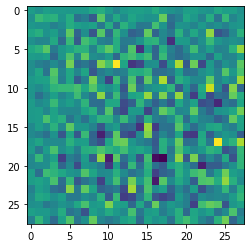

In [107]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:, :,0])

In [108]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
                                     
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [109]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00058276]], shape=(1, 1), dtype=float32)


In [110]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [111]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return real_loss+fake_loss

In [112]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [113]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [114]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [115]:
EPOCHS = 50
noise_dim = 100
num_of_examples_to_generate = 16
seed = tf.random.normal([num_of_examples_to_generate, noise_dim])

In [120]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [121]:
def train(dataset, epochs):
    for epoch in range(epochs):
      start = time.time()
      for image_batch in dataset:
        train_step(image_batch)

      display.clear_output(wait=True)
      generate_and_save_images(generator, epochs+1, seed)
      if (epoch+1)%15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
      print("Time for epoch {} is {} sec".format(epoch+1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [128]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5)
      plt.axis('off')
    plt.savefig('image_at_epoch{:04d}.png'.format(epoch))
    plt.show()      

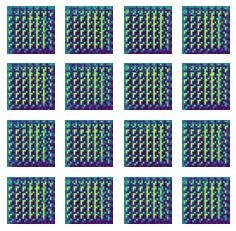

Time for epoch 48 is 24.031683683395386 sec


In [ ]:
train(train_dataset, EPOCHS)

In [132]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [135]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch{:04d}.png'.format(epoch_no))

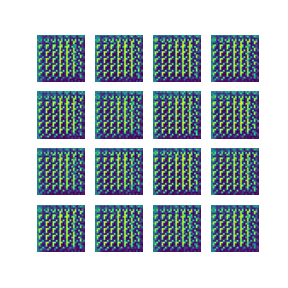

In [136]:
display_image(EPOCHS)

In [137]:
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)  


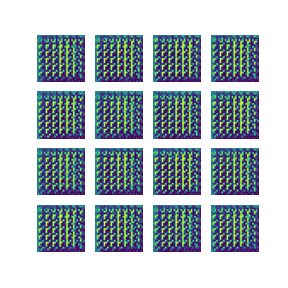

In [138]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)